# Load Packages

In [20]:
import json
import pandas as pd
import numpy as np
import math
import os
import glob

# Machine learning packages
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Load Data

In [23]:
# Load event data files
print("\nLoading all required data sources...")

# Directory containing all event data files
events_dir = '/Users/julianball/Downloads/wyscout_course/events_data'

# Load data from all JSON files in the directory
all_data = []
print(f"Looking for event data in directory: {events_dir}...")

# Check if the directory exists
try:
    # Get list of all JSON files
    if not os.path.exists(events_dir):
        print(f"ERROR: Directory '{events_dir}' not found!")
        print("Please create this directory and place your event JSON files there.")
        print("Alternatively, modify the 'events_dir' variable to point to your actual data location.")
        # Create empty lists so the rest of the script can continue with sample/dummy data
        json_files = []
        total_files = 0
    else:
        json_files = [f for f in os.listdir(events_dir) if f.endswith('.json')]
        total_files = len(json_files)
        print(f"Found {total_files} JSON files to process")
except Exception as e:
    print(f"Error accessing directory: {e}")
    json_files = []
    total_files = 0

# Load player information
print("\nLoading player information...")
try:
    players_path = '/Users/julianball/Downloads/wyscout_course/players.parquet'
    players_df = pd.read_parquet(players_path)
    print(f"Loaded player data for {len(players_df)} players")
    print(f"Player data columns: {players_df.columns.tolist()}")
    
    # Create a mapping from player_id to position/role for later use
    player_id_to_position = dict(zip(players_df['player_id'], players_df['role']))
    print(f"Created player position mapping for {len(player_id_to_position)} players")
except Exception as e:
    print(f"Error loading player data: {e}")
    player_id_to_position = {}

# Load minutes data
print("\nLoading player minutes data...")

# Load player minutes data from minutes.parquet file
minutes_path = '/Users/julianball/Downloads/wyscout_course/minutes.parquet'
print(f"Loading player minutes data from {minutes_path}...")

try:
    # Load minutes data from parquet file
    minutes_df = pd.read_parquet(minutes_path)
    print(f"Loaded minutes data for {len(minutes_df)} player-match records")
    
    # Debug information about minutes data
    print(f"Minutes data columns: {minutes_df.columns.tolist()}")
    print(f"Sample minutes values: {minutes_df['minutes_played'].head().tolist()}")
    print(f"Total minutes in dataset: {minutes_df['minutes_played'].sum()}")
    
    # Aggregate minutes by player_id
    player_minutes_df = minutes_df.groupby('player_id').agg({
        'minutes_played': 'sum',  # Use minutes_played instead of minutes
        'position': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
        'match_id': 'nunique',
        'team_id': 'first'
    }).reset_index()
    
    player_minutes_df.rename(columns={
        'match_id': 'matches_played',
        'position': 'wyscout_position',
        'minutes_played': 'minutes'  # Rename to be consistent with other code
    }, inplace=True)
    
    # Calculate minutes per 90
    player_minutes_df['matches_90'] = player_minutes_df['minutes'] / 90
    
    print(f"Processed minutes data for {len(player_minutes_df)} players")
    print(f"Average minutes per player: {player_minutes_df['minutes'].mean():.1f}")
    print(f"Average matches per player: {player_minutes_df['matches_played'].mean():.1f}")
    print(f"Total minutes across all players: {player_minutes_df['minutes'].sum()}")
    
    # Create mapping dictionaries for easy lookup
    player_id_to_minutes = dict(zip(player_minutes_df['player_id'], player_minutes_df['minutes']))
    player_id_to_matches = dict(zip(player_minutes_df['player_id'], player_minutes_df['matches_played']))
    
    # Also create a position mapping from the minutes data if available
    if 'wyscout_position' in player_minutes_df.columns:
        players_position_from_minutes = dict(zip(player_minutes_df['player_id'], player_minutes_df['wyscout_position']))
        # Update position mapping with any positions from minutes data not in player data
        for player_id, position in players_position_from_minutes.items():
            if player_id not in player_id_to_position:
                player_id_to_position[player_id] = position
except Exception as e:
    print(f"Error loading minutes data: {e}")
    player_minutes_df = None
    player_id_to_minutes = {}
    player_id_to_matches = {}

# Process files with progress updates
for i, file_name in enumerate(json_files):
    try:
        with open(os.path.join(events_dir, file_name), 'r') as f:
            data = json.load(f)
            all_data.extend(data)
        
        # Show progress every 50 files
        if (i + 1) % 50 == 0 or i == total_files - 1:
            print(f"Processed {i+1}/{total_files} files ({(i+1)/total_files*100:.1f}%)")
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

print(f"Loaded {len(all_data)} total events from {total_files} files")

# Convert events to a DataFrame
df = pd.DataFrame(all_data)


Loading all required data sources...
Looking for event data in directory: /Users/julianball/Downloads/wyscout_course/events_data...
Found 288 JSON files to process

Loading player information...
Loaded player data for 659 players
Player data columns: ['player_id', 'short_name', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'passport', 'birth_country', 'image_url', 'gender', 'foot', 'role', 'team_id', 'season_id']
Created player position mapping for 659 players

Loading player minutes data...
Loading player minutes data from /Users/julianball/Downloads/wyscout_course/minutes.parquet...
Loaded minutes data for 8768 player-match records
Minutes data columns: ['player_id', 'minutes_played', 'position_provider', 'position', 'jersey_number', 'team_id', 'match_id', 'yellow_card', 'bookings', 'red_card', 'goals', 'assists', 'sub_in', 'sub_out', 'minutes', 'own_goals', 'starting']
Sample minutes values: [61, 61, 81, 81, 84]
Total minutes in dataset: 585642
Processed minutes data

# Data Preprocessing

In [25]:
# Add match period as numeric (1H = 1, 2H = 2)
df['period_num'] = df['matchPeriod'].apply(lambda x: 1 if x == '1H' else 2)

# Calculate seconds from match start
df['time_seconds'] = ((df['period_num'] - 1) * 45 * 60) + (df['minute'] * 60) + df['second']

# Sort by time
df = df.sort_values('time_seconds')

# Filter for pass events
pass_filter = df['type'].apply(lambda x: x.get('primary') == 'pass' if isinstance(x, dict) else False)
successful_filter = df['pass'].apply(lambda x: x.get('accurate') == True if isinstance(x, dict) else False)
successful_pass_df = df[pass_filter & successful_filter].copy()

# Get pass start and end locations
successful_pass_df['start_x'] = successful_pass_df['location'].apply(lambda x: x.get('x') if isinstance(x, dict) else None)
successful_pass_df['start_y'] = successful_pass_df['location'].apply(lambda x: x.get('y') if isinstance(x, dict) else None)

# For each pass, get end location from pass details
successful_pass_df['end_x'] = successful_pass_df['pass'].apply(lambda x: x.get('endLocation', {}).get('x') if isinstance(x, dict) else None)
successful_pass_df['end_y'] = successful_pass_df['pass'].apply(lambda x: x.get('endLocation', {}).get('y') if isinstance(x, dict) else None)

# Drop rows with missing location data
successful_pass_df = successful_pass_df.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y'])

# Convert coordinates to numeric
for col in ['start_x', 'start_y', 'end_x', 'end_y']:
    successful_pass_df[col] = pd.to_numeric(successful_pass_df[col])

# Extract player information
successful_pass_df['player_id'] = successful_pass_df['player'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
successful_pass_df['player_name'] = successful_pass_df['player'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
successful_pass_df['event_position'] = successful_pass_df['player'].apply(lambda x: x.get('position') if isinstance(x, dict) else None)

# Load player data for positions
players_path = '/Users/julianball/Downloads/wyscout_course/players.parquet'
players_df = pd.read_parquet(players_path)
# Create a mapping from player_id to role (position)
player_id_to_role = dict(zip(players_df['player_id'], players_df['role']))

# Add position from players.parquet, fallback to event position if not found
successful_pass_df['player_position'] = successful_pass_df['player_id'].map(player_id_to_role).fillna(successful_pass_df['event_position'])

# Extract team information
successful_pass_df['team_id'] = successful_pass_df['team'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
successful_pass_df['team_name'] = successful_pass_df['team'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)

# Extract match information
successful_pass_df['match_id'] = successful_pass_df['matchId']

# Initialize shot column
successful_pass_df['shot'] = 0

print("Preprocessing complete. Found", len(successful_pass_df), "successful passes with location data.")
print("Columns in pass data:", successful_pass_df.columns.tolist())

Preprocessing complete. Found 208444 successful passes with location data.
Columns in pass data: ['id', 'matchId', 'matchPeriod', 'minute', 'second', 'matchTimestamp', 'videoTimestamp', 'relatedEventId', 'type', 'location', 'team', 'opponentTeam', 'player', 'pass', 'shot', 'groundDuel', 'aerialDuel', 'infraction', 'carry', 'possession', 'period_num', 'time_seconds', 'start_x', 'start_y', 'end_x', 'end_y', 'player_id', 'player_name', 'event_position', 'player_position', 'team_id', 'team_name', 'match_id']


# 1. Identify Passes Before Shots (Within 15 Seconds)

In [29]:
# Extract shot events only - xG will be calculated in Step 3
print("\nIdentifying shots...")
shot_df = df[df['type'].apply(lambda x: x.get('primary') == 'shot' if isinstance(x, dict) else False)]

# Also extract match ID for shots
shot_df['match_id'] = shot_df['matchId']

# Extract shot coordinates for later use
shot_df['shot_x'] = None
shot_df['shot_y'] = None

for idx, shot in shot_df.iterrows():
    # Extract shot location
    if isinstance(shot.get('location'), dict):
        shot_x = shot['location'].get('x')
        shot_y = shot['location'].get('y')
        
        if shot_x is not None and shot_y is not None:
            shot_df.loc[idx, 'shot_x'] = shot_x
            shot_df.loc[idx, 'shot_y'] = shot_y

print(f"Identified {len(shot_df)} shots across all matches")

# For each shot, find passes within 15 seconds before IN THE SAME MATCH
print("\nIdentifying passes within 15 seconds before each shot...")
shot_pass_count = 0

for _, shot_row in shot_df.iterrows():
    shot_time = shot_row['time_seconds']
    shot_match = shot_row['matchId']  # Get the match ID for this shot
    shot_team = shot_row['team'].get('id') if isinstance(shot_row['team'], dict) else None
    
    # Find passes by the same team, in the same match, within 15 seconds before this shot
    preceding_passes = successful_pass_df[
        (successful_pass_df['matchId'] == shot_match) &  # SAME MATCH
        (successful_pass_df['time_seconds'] < shot_time) & 
        (successful_pass_df['time_seconds'] >= shot_time - 15) & 
        (successful_pass_df['team_id'] == shot_team)  # SAME TEAM
    ]
    
    # Mark these passes as leading to a shot
    for pass_idx in preceding_passes.index:
        successful_pass_df.at[pass_idx, 'shot'] = 1
        shot_pass_count += 1
        
print(f"Found {shot_pass_count} unique passes made within 15 seconds before shots")
print(f"This represents {shot_pass_count/len(successful_pass_df):.2%} of all passes in the dataset")

# Count how many shots had at least one preceding pass
shots_with_passes = shot_df[shot_df['matchId'].isin(successful_pass_df[successful_pass_df['shot'] == 1]['matchId'])]
print(f"Found preceding passes for {len(shots_with_passes)} out of {len(shot_df)} shots ({len(shots_with_passes)/len(shot_df):.2%})")

# Initialize chain ID and identify chains of passes by the same team in the same match
successful_pass_df['chain'] = 0

# Sort by match ID and time for chain identification
successful_pass_df = successful_pass_df.sort_values(['match_id', 'time_seconds'])

# Use a unique chain ID for each separate chain
chain_id = 1

# Tracking the last pass information
last_team = None
last_time = 0
last_match = None

# Loop through passes to assign chain IDs - ensure chains are within same match
for idx, row in successful_pass_df.iterrows():
    current_team = row['team_id']
    current_time = row['time_seconds']
    current_match = row['match_id']
    
    # Start a new chain if: different match, different team, or time gap > 15 seconds
    if (current_match != last_match) or (current_team != last_team) or (current_time - last_time > 15):
        chain_id += 1
    
    # Assign chain ID with match_id prefix to ensure unique chains across matches
    match_specific_chain_id = f"{current_match}_{chain_id}"
    successful_pass_df.loc[idx, 'chain'] = match_specific_chain_id
    
    # Update tracking variables
    last_team = current_team
    last_time = current_time
    last_match = current_match

# Prepare a dataframe for analysis
final_df = successful_pass_df[['start_x', 'start_y', 'end_x', 'end_y', 'shot', 'chain', 
                             'player_name', 'team_name', 'player_position', 'event_position',
                             'time_seconds', 'player_id', 'match_id']].copy()

print(f"Identified {final_df['chain'].nunique()} unique pass chains")
print(f"Average passes per chain: {len(final_df) / final_df['chain'].nunique():.2f}")
if 'player_id' in final_df.columns:
    # Convert to numeric, coercing errors to NaN
    final_df['player_id'] = pd.to_numeric(final_df['player_id'], errors='coerce')
    # Fill any missing values with -1
    final_df = final_df[final_df['player_id'].notna()]
    final_df['player_id'] = final_df['player_id'].astype(int)

    print(f"Successfully retained player_id column with {final_df['player_id'].nunique()} unique players")

# Ensure other columns are of the right type
final_df['shot'] = final_df['shot'].astype(int)
# Chain is now a string with format: "match_id_chain_id"

# We'll set player position after loading all the data from the minutes/players parquet files

# Display summary
print(f"\nANALYSIS SUMMARY:")
print(f"Total successful passes analyzed: {len(final_df)}")
print(f"Passes leading to shots within 15 seconds: {final_df['shot'].sum()} ({final_df['shot'].sum()/len(final_df)*100:.2f}%)")
final_df.head()


Identifying shots...


/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/3355714657.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df['match_id'] = shot_df['matchId']
/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/3355714657.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df['shot_x'] = None
/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/3355714657.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Identified 6698 shots across all matches

Identifying passes within 15 seconds before each shot...
Found 17211 unique passes made within 15 seconds before shots
This represents 8.26% of all passes in the dataset
Found preceding passes for 6698 out of 6698 shots (100.00%)


/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/3355714657.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5588080_2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  successful_pass_df.loc[idx, 'chain'] = match_specific_chain_id


Identified 40278 unique pass chains
Average passes per chain: 5.18
Successfully retained player_id column with 535 unique players

ANALYSIS SUMMARY:
Total successful passes analyzed: 208444
Passes leading to shots within 15 seconds: 16418 (7.88%)


,start_x,start_y,end_x,end_y,shot,chain,player_name,team_name,player_position,event_position,time_seconds,player_id,match_id
317042,51,50,38,61,0,5588080_2,Andreas Pereira,Fulham,Midfielder,RCMF,4,240445,5588080
317043,38,61,24,81,0,5588080_2,S. Lukić,Fulham,Midfielder,LCMF,6,237269,5588080
317044,24,81,64,91,0,5588080_2,I. Diop,Fulham,Defender,RCB,11,286380,5588080
317049,36,1,46,6,0,5588080_3,K. Mainoo,Manchester United,Midfielder,LDMF,17,692544,5588080
317057,19,23,33,24,0,5588080_4,L. Martínez,Manchester United,Defender,LCB,64,488453,5588080


# 2. Logistic Regression to Precit Shot Probability

In [31]:
print("\nBuilding logistic regression model for shot probability...")

# Features: start and end coordinates
# Note: We only use spatial features for the model, not the player information
X = final_df[['start_x', 'start_y', 'end_x', 'end_y']]
y = final_df['shot']

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate model
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC score: {auc:.4f}")
    
# Apply model to predict shot probability for all passes
final_df['shot_probability'] = model.predict_proba(final_df[['start_x', 'start_y', 'end_x', 'end_y']])[:, 1]

# Print distribution of shot probabilities
print(f"\nShot probability distribution:")
print(f"Mean: {final_df['shot_probability'].mean():.4f}")
print(f"Max: {final_df['shot_probability'].max():.4f}")
print(f"Min: {final_df['shot_probability'].min():.4f}")


Building logistic regression model for shot probability...
Model AUC score: 0.7768

Shot probability distribution:
Mean: 0.0786
Max: 0.4223
Min: 0.0032


# 3. Calculate XG Based on Shot Location


Calculating xG based on shot angle...
Total shots: 6698
Total goals detected: 770
Goal percentage: 11.50%

Fitting data information:
Number of angle bins with data: 29
Angle bin range: 0.0 to 180.0 degrees
Goal probability range: 0.0000 to 1.0000

Sample angle bins:
Angle bin: 180.0°, Shots: 2.0, Goals: 2.0, Probability: 1.0000
Angle bin: 144.0°, Shots: 1.0, Goals: 1.0, Probability: 1.0000
Angle bin: 84.0°, Shots: 9.0, Goals: 8.0, Probability: 0.8889
Angle bin: 92.0°, Shots: 4.0, Goals: 3.0, Probability: 0.7500
Angle bin: 60.0°, Shots: 12.0, Goals: 7.0, Probability: 0.5833
Fitted parameters: a=-1.89, b=3.69


/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/2183518731.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df['angle_radians'] = shot_df.apply(
/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/2183518731.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df['angle_degrees'] = shot_df['angle_radians'] * (180 / math.pi)
/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/2183518731.py:49: SettingWithCopyWarning: 
A value is trying to be set on a c

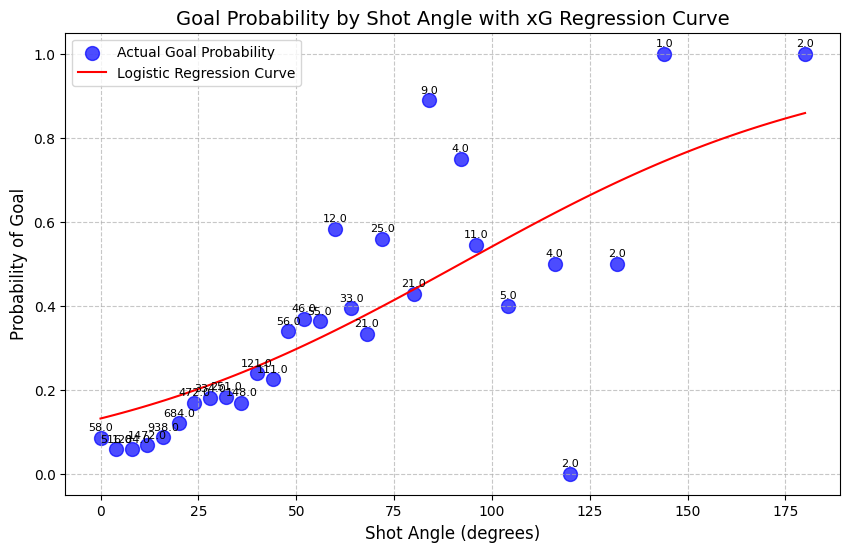


xG Model Summary:
Total shots with valid angles: 6698
Average xG: 0.1905
Min xG: 0.1314
Max xG: 0.8588
Goals with valid xG values: 770


In [35]:
print("\nCalculating xG based on shot angle...")

# Function to calculate the angle to goal
def calculate_shot_angle(x, y):
    # Set goal posts coordinates in the 100x100 coordinate system
    # Standard goal width is 7.32m, convert to coordinate system
    # The goal is positioned at x=100, and centered on y=50
    goal_width = 7.32  # standard width in meters
    # Scale factor to convert from meters to coordinate system units
    # Assuming a standard pitch of 105x68 meters mapped to 100x100 coordinate system
    scale_factor = 100/105  # coordinate units per meter
    goal_width_coords = goal_width * scale_factor
    
    # Goal post coordinates
    goal_y_min = 50 - goal_width_coords/2
    goal_y_max = 50 + goal_width_coords/2
    goal_x = 100
    
    # Calculate distances to each post
    d1 = math.sqrt((x - goal_x)**2 + (y - goal_y_min)**2)  # distance to left post
    d2 = math.sqrt((x - goal_x)**2 + (y - goal_y_max)**2)  # distance to right post
    d3 = math.sqrt((goal_y_max - goal_y_min)**2)  # distance between posts
    
    # Use law of cosines to find the angle
    # cos(angle) = (a² + b² - c²) / (2ab)
    # where a and b are distances to posts, c is distance between posts
    cos_angle = (d1**2 + d2**2 - d3**2) / (2 * d1 * d2)
    
    # Clamp cos_angle to [-1, 1] range to handle floating point errors
    cos_angle = max(min(cos_angle, 1), -1)
    
    # Calculate angle in radians
    angle = math.acos(cos_angle)
    
    return angle

# Add angle to each shot
shot_df['angle_radians'] = shot_df.apply(
    lambda row: calculate_shot_angle(row['shot_x'], row['shot_y'])
    if not pd.isna(row['shot_x']) and not pd.isna(row['shot_y']) else None, 
    axis=1
)

# Convert angle to degrees
shot_df['angle_degrees'] = shot_df['angle_radians'] * (180 / math.pi)

# Add a column indicating whether the shot resulted in a goal
# Based on our analysis, goals are identified by the isGoal field in the shot dictionary
shot_df['is_goal'] = shot_df['shot'].apply(
    lambda x: x.get('isGoal') == True if isinstance(x, dict) else False
)

# Print goal statistics to debug
print(f"Total shots: {len(shot_df)}")
print(f"Total goals detected: {shot_df['is_goal'].sum()}")
print(f"Goal percentage: {shot_df['is_goal'].mean():.2%}")

# Create bins of 4 degrees each
bin_size = 4
shot_df['angle_bin'] = (shot_df['angle_degrees'] // bin_size) * bin_size

# Calculate goal probability for each bin
angle_bin_stats = shot_df.groupby('angle_bin').agg(
    total_shots=('is_goal', 'count'),
    total_goals=('is_goal', 'sum'),
).reset_index()

# Calculate goal probability
angle_bin_stats['goal_probability'] = angle_bin_stats['total_goals'] / angle_bin_stats['total_shots']

# Fit logistic regression model: xG = 1 / (1 + e^-(-3.0 + 5.0 * (angle/π)))
from scipy import optimize

# Define logistic function for fitting
def logistic_function(x, a, b):
    # This follows the formula from the memory: xG = 1 / (1 + e^-(a + b * (angle/π)))
    return 1 / (1 + np.exp(-(a + b * (x / math.pi))))

# Filter out rows with NaN values
valid_data = angle_bin_stats.dropna(subset=['angle_bin', 'goal_probability'])

# Convert bin centers to radians
bin_centers_radians = valid_data['angle_bin'] * (math.pi / 180)

# Initial parameter guesses based on the formula in the memory
# Using the exact values from the memory: xG = 1 / (1 + e^-(-3.0 + 5.0 * (angle/π)))
# Note that in this formula, a = -3.0 and b = 5.0
initial_params = [-3.0, 5.0]

# Print some diagnostics about the data we're using for fitting
print(f"\nFitting data information:")
print(f"Number of angle bins with data: {len(valid_data)}")
if len(valid_data) > 0:
    print(f"Angle bin range: {valid_data['angle_bin'].min()} to {valid_data['angle_bin'].max()} degrees")
    print(f"Goal probability range: {valid_data['goal_probability'].min():.4f} to {valid_data['goal_probability'].max():.4f}")
    
    # Print some sample bins for verification
    print("\nSample angle bins:")
    sample = valid_data.sort_values('goal_probability', ascending=False).head(5)
    for _, row in sample.iterrows():
        print(f"Angle bin: {row['angle_bin']}°, Shots: {row['total_shots']}, Goals: {row['total_goals']}, Probability: {row['goal_probability']:.4f}")

# Fit the curve or use known parameters
try:
    # Only fit if we have enough data points with reasonable values
    if len(valid_data) > 5 and valid_data['goal_probability'].max() > 0.05:
        params, _ = optimize.curve_fit(
            logistic_function, 
            bin_centers_radians, 
            valid_data['goal_probability'],
            p0=initial_params,
            bounds=([-10, 0], [0, 10])  # Reasonable bounds for parameters
        )
        a_fit, b_fit = params
        print(f"Fitted parameters: a={a_fit:.2f}, b={b_fit:.2f}")
    else:
        # Use default parameters from the memory if not enough good data
        a_fit, b_fit = -3.0, 5.0
        print("Using default parameters from memory: a=-3.0, b=5.0")
        print("(Either not enough data points or goal probabilities too low)")

    # Function to calculate xG based on fitted parameters
    def calculate_xg(angle_radians):
        if pd.isna(angle_radians):
            return None
        # Use the logistic function to calculate xG
        xg_value = logistic_function(angle_radians, a_fit, b_fit)
        # Ensure the value is in the range [0, 1]
        return max(0, min(1, xg_value))
    
    # Add xG to the shot dataframe
    shot_df['xG'] = shot_df['angle_radians'].apply(calculate_xg)

    # Plot the results
    try:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))

        # Create a single scatter plot with uniform point size
        # Use a consistent point size (s=100) for all data points
        plt.scatter(valid_data['angle_bin'], valid_data['goal_probability'], 
                   s=100, color='blue', alpha=0.7, label='Actual Goal Probability')
        
        # Add annotations showing number of shots in each bin
        for i, row in valid_data.iterrows():
            plt.annotate(f"{row['total_shots']}", 
                        (row['angle_bin'], row['goal_probability']),
                        textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

        # Generate points for the regression curve
        x_curve = np.linspace(0, max(valid_data['angle_bin']), 100)
        x_curve_radians = x_curve * (math.pi / 180)
        y_curve = [logistic_function(x, a_fit, b_fit) for x in x_curve_radians]

        # Plot the regression curve
        plt.plot(x_curve, y_curve, 'r-', label='Logistic Regression Curve')

        # Labels and title
        plt.xlabel('Shot Angle (degrees)', fontsize=12)
        plt.ylabel('Probability of Goal', fontsize=12)
        plt.title('Goal Probability by Shot Angle with xG Regression Curve', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)

        # Show the plot
        plt.show()

        # Print summary statistics
        print(f"\nxG Model Summary:")
        print(f"Total shots with valid angles: {shot_df['angle_radians'].notna().sum()}")
        print(f"Average xG: {shot_df['xG'].mean():.4f}")
        print(f"Min xG: {shot_df['xG'].min():.4f}")
        print(f"Max xG: {shot_df['xG'].max():.4f}")
        print(f"Goals with valid xG values: {shot_df[shot_df['is_goal'] & shot_df['xG'].notna()].shape[0]}")


    except ImportError:
        print("Matplotlib not installed. Skipping plots.")
    except Exception as e:
        print(f"Error plotting xG data: {e}")

except Exception as e:
    print(f"Error fitting xG model: {e}")
    # Add empty xG column to avoid errors in later code
    shot_df['xG'] = None


# 4. Map Shot XG Values to Pass Chains and Calculate xDanger

In [45]:
print("\nMapping shot xG values to pass chains...")

# First, add shot_id column to shot_df to track shots
shot_df['shot_id'] = shot_df.index

# Initialize xG column in final_df with zeros
final_df['xG'] = 0.0

# Create mapping from pass chains to shot coordinates and xG
chain_to_shot_mapping = {}

# For each shot, find the chain that led to it
for _, shot_row in shot_df.iterrows():
    if pd.isna(shot_row['xG']):
        continue
        
    shot_match = shot_row['match_id']
    shot_time = shot_row['time_seconds']
    shot_team = shot_row['team'].get('id') if isinstance(shot_row['team'], dict) else None
    shot_xg = shot_row['xG']
    
    # Find the last pass in the chain that led to this shot
    # This must be by the same team, in the same match, and within 15 seconds before the shot
    last_pass = successful_pass_df[
        (successful_pass_df['match_id'] == shot_match) &
        (successful_pass_df['team_id'] == shot_team) &
        (successful_pass_df['time_seconds'] < shot_time) &
        (successful_pass_df['time_seconds'] >= shot_time - 15)
    ].sort_values('time_seconds', ascending=False)
    
    if len(last_pass) > 0:
        # Get the chain ID of the last pass
        chain_id = last_pass.iloc[0]['chain']
        chain_to_shot_mapping[chain_id] = shot_xg

# Map xG values to all passes in the chains that led to shots
for chain_id, xg in chain_to_shot_mapping.items():
    # Update all passes in this chain with the shot's xG value
    final_df.loc[final_df['chain'] == chain_id, 'xG'] = xg

# Print summary statistics for the mapped xG values
chains_with_xg = final_df[final_df['xG'] > 0]['chain'].nunique()
print(f"Mapped xG values to {chains_with_xg} pass chains out of {final_df['chain'].nunique()} total chains")
print(f"Average xG of pass chains leading to shots: {final_df[final_df['xG'] > 0]['xG'].mean():.4f}")
print(f"Maximum xG of any pass chain: {final_df['xG'].max():.4f}")

# Check if the distribution makes sense
non_zero_xg_count = (final_df['xG'] > 0).sum()
xg_zero_count = (final_df['xG'] == 0).sum()
print(f"Passes with xG > 0: {non_zero_xg_count} ({non_zero_xg_count/len(final_df):.2%})")
print(f"Passes with xG = 0: {xg_zero_count} ({xg_zero_count/len(final_df):.2%})")

# Calculate Expected Danger (xDanger) as the product of shot probability and xG
print("\nCalculating Expected Danger (xDanger) values...")
final_df['xDanger'] = final_df['shot_probability'] * final_df['xG']

# Print summary statistics for xDanger values
print(f"xDanger summary statistics:")
print(f"Mean xDanger: {final_df['xDanger'].mean():.6f}")
print(f"Median xDanger: {final_df['xDanger'].median():.6f}")
print(f"Max xDanger: {final_df['xDanger'].max():.6f}")
print(f"Min xDanger: {final_df['xDanger'].min():.6f}")

# Analyze proportion of passes by xDanger value
low_danger = (final_df['xDanger'] < 0.01).sum() / len(final_df)
medium_danger = ((final_df['xDanger'] >= 0.01) & (final_df['xDanger'] < 0.05)).sum() / len(final_df)
high_danger = (final_df['xDanger'] >= 0.05).sum() / len(final_df)

print(f"Low xDanger passes (<0.01): {low_danger:.2%}")
print(f"Medium xDanger passes (0.01-0.05): {medium_danger:.2%}")
print(f"High xDanger passes (≥0.05): {high_danger:.2%}")



Mapping shot xG values to pass chains...


/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_23264/2755710335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df['shot_id'] = shot_df.index


Mapped xG values to 5019 pass chains out of 40278 total chains
Average xG of pass chains leading to shots: 0.1863
Maximum xG of any pass chain: 0.8588
Passes with xG > 0: 34886 (16.74%)
Passes with xG = 0: 173558 (83.26%)

Calculating Expected Danger (xDanger) values...
xDanger summary statistics:
Mean xDanger: 0.003774
Median xDanger: 0.000000
Max xDanger: 0.359382
Min xDanger: 0.000000
Low xDanger passes (<0.01): 88.94%
Medium xDanger passes (0.01-0.05): 9.43%
High xDanger passes (≥0.05): 1.63%


# 5. Rank Players by xDanger and Dangerous Passes per 90 (Grouped by Position)


Creating player analysis dataframe...
Added minutes data from player_minutes_df
Filtered out 127 players with less than 300 minutes of playing time.

Ranking players within position groups...
Ranked 145 Defenders
Ranked 126 Midfielders
Ranked 33 Goalkeepers
Ranked 103 Forwards

Player Analysis Summary:
Total players analyzed: 407
Top xDanger_per_90 player: J. Grealish (0.3869)
Average xDanger_per_90: 0.1193
Average danger passes per 90: 2.47

xDanger per 90 by position:
Midfielder: 0.1486 (126 players)
Forward: 0.1382 (103 players)
Defender: 0.1056 (145 players)
Goalkeeper: 0.0087 (33 players)

Top 5 players by xDanger_per_90:
1. J. Grealish (Forward): 0.3869 xD/90, 6.87 danger passes/90
2. K. De Bruyne (Midfielder): 0.3818 xD/90, 6.30 danger passes/90
3. T. Cairney (Midfielder): 0.3567 xD/90, 7.18 danger passes/90
4. R. Sterling (Forward): 0.3468 xD/90, 3.31 danger passes/90
5. R. Nelson (Forward): 0.3225 xD/90, 6.61 danger passes/90

Creating position-specific scatter plots...

Crea

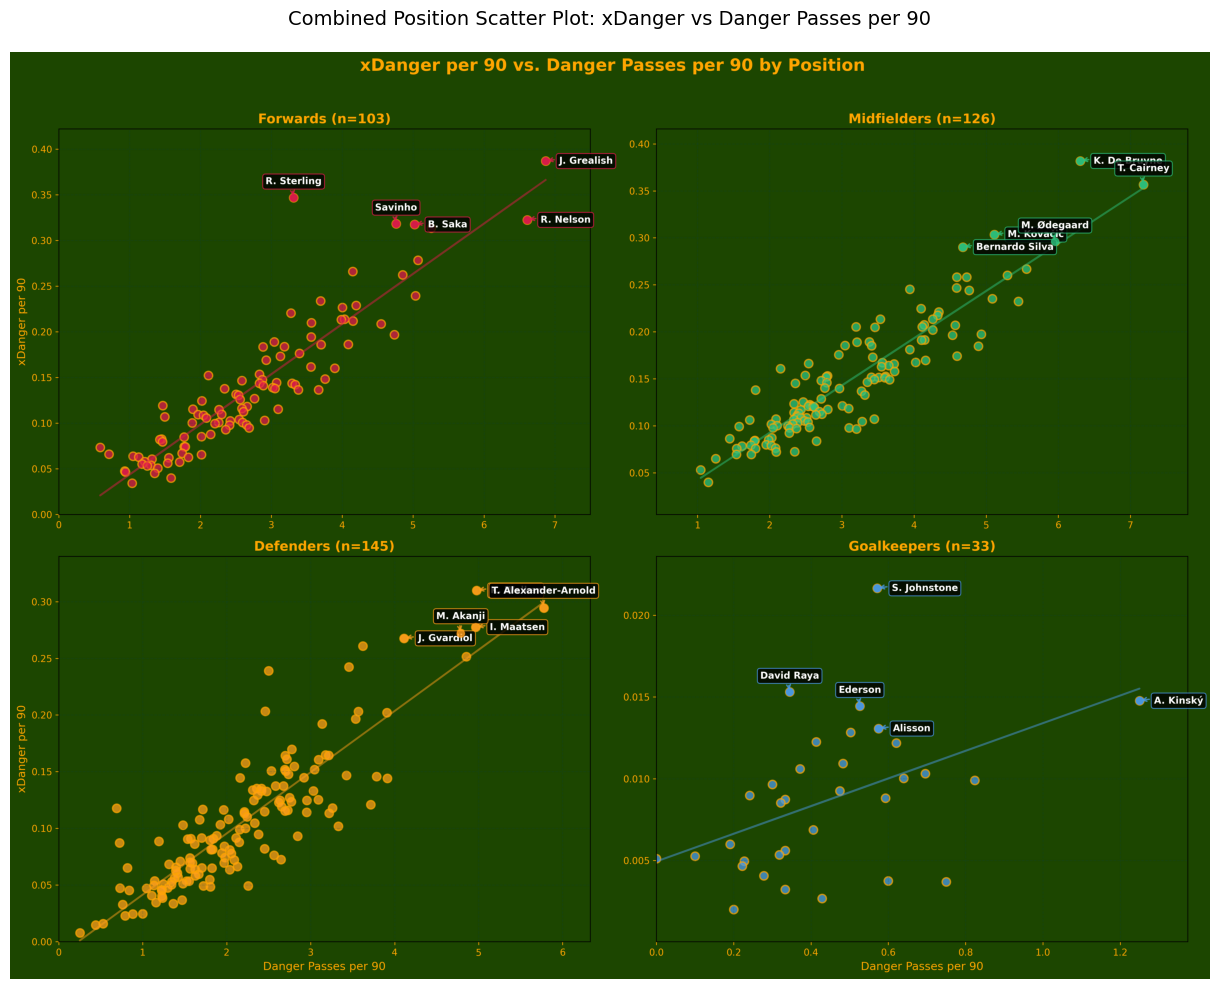


Forward Top Players Table:


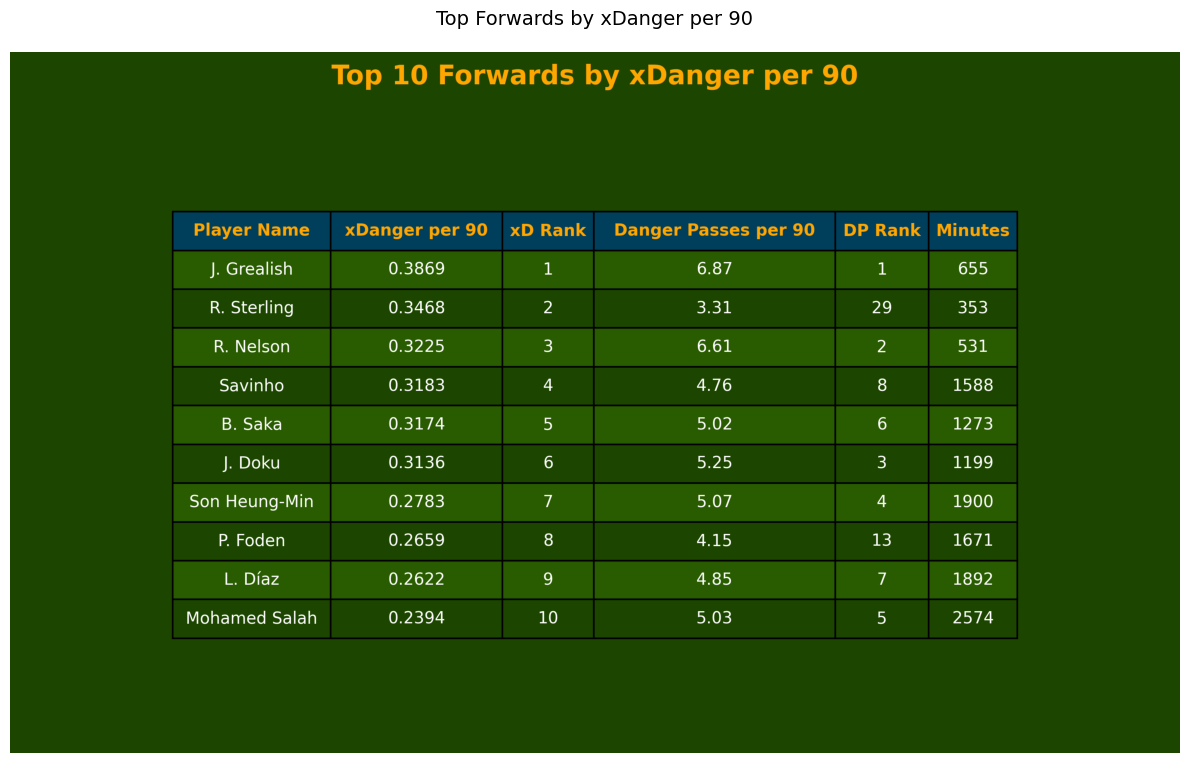


Midfielder Top Players Table:


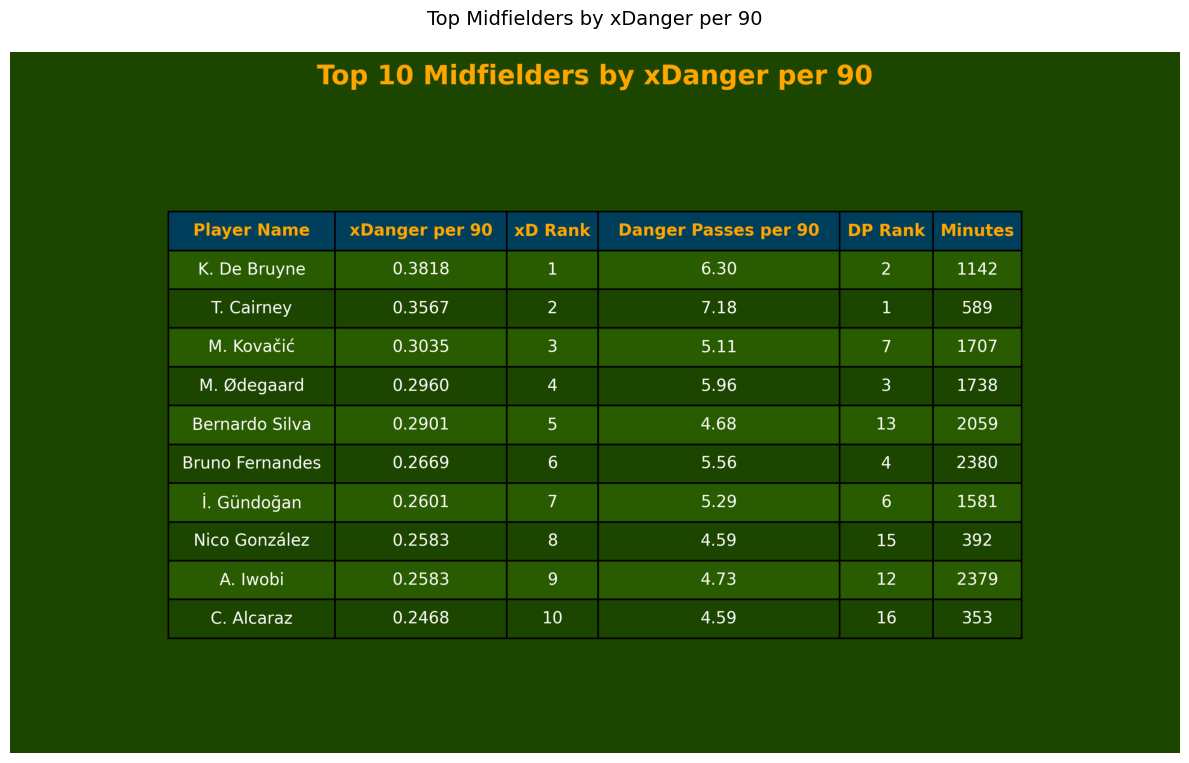


Defender Top Players Table:


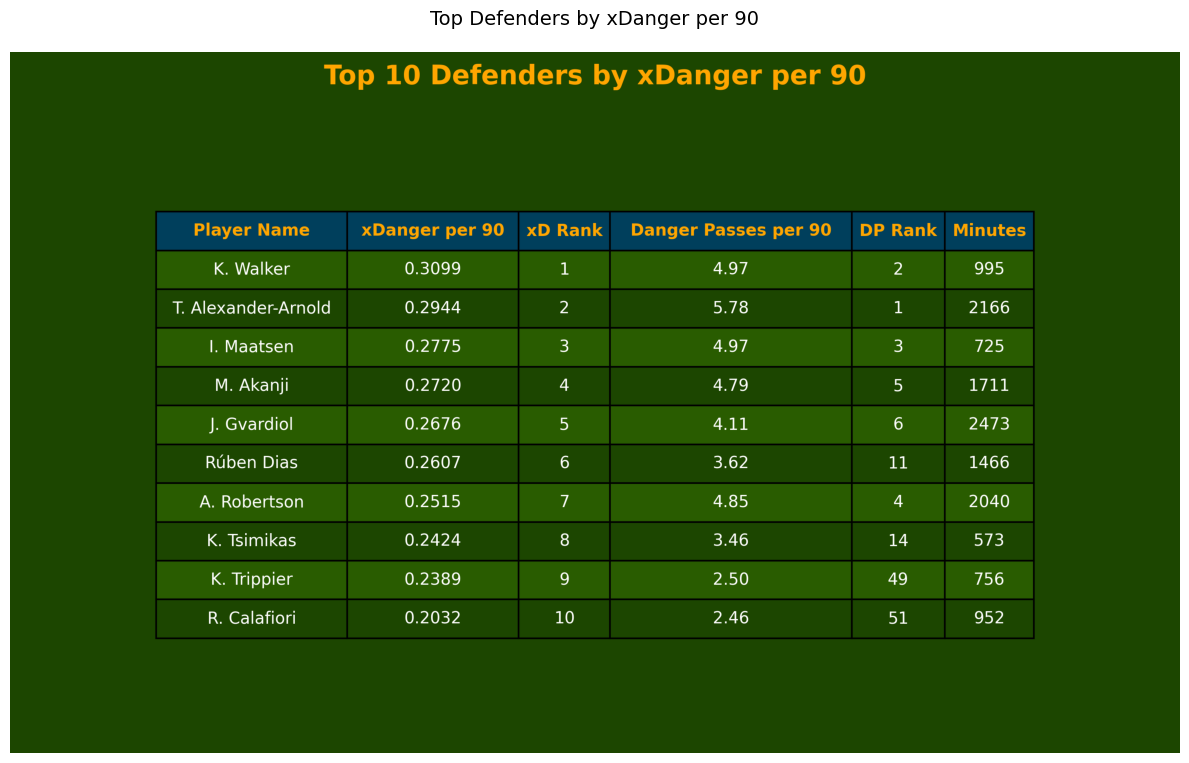


Goalkeeper Top Players Table:


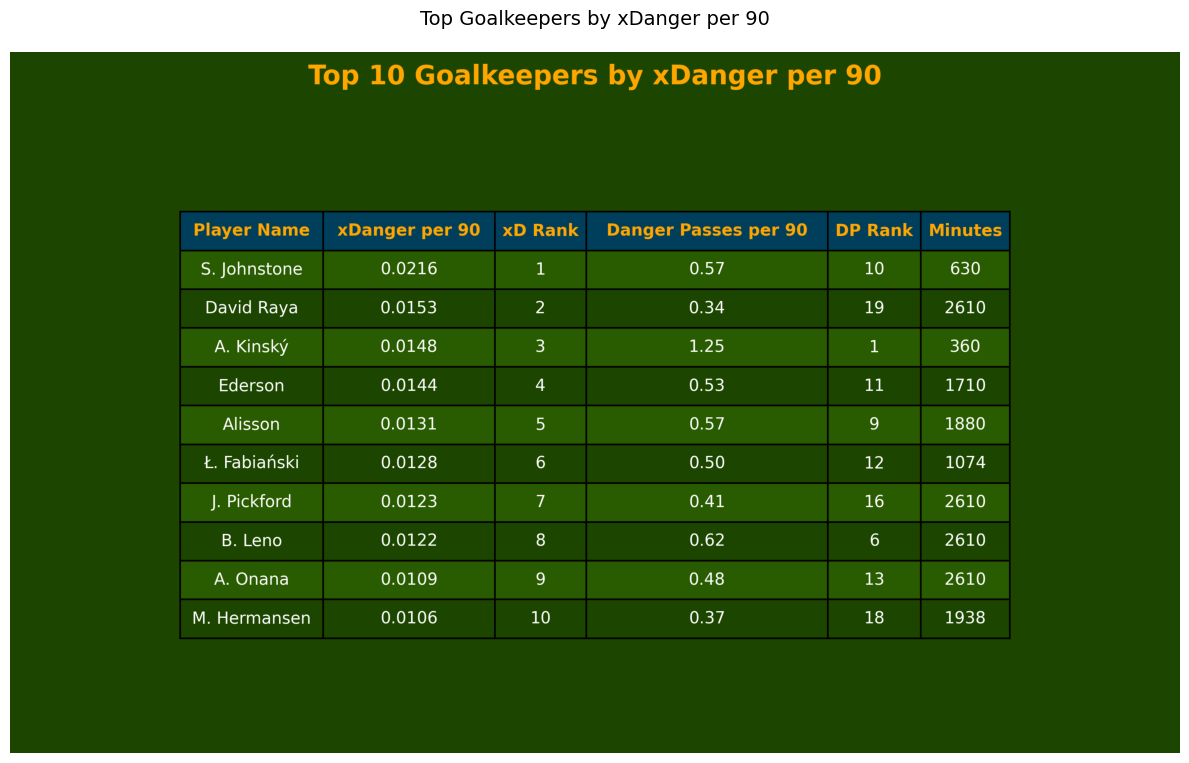


Analysis complete.


In [49]:
print("\nCreating player analysis dataframe...")

# Define danger passes as those in a chain 15 seconds before a shot
# We already have this information in the 'shot' column (1 for passes leading to shots, 0 otherwise)
final_df['is_danger_pass'] = final_df['shot'] == 1

# Group data by player
player_stats = final_df.groupby(['player_id', 'player_name', 'player_position']).agg(
    total_passes=('player_id', 'count'),
    danger_passes=('is_danger_pass', 'sum'),  # Count of passes leading to shots
    xDanger=('xDanger', 'sum')                # Sum of expected danger
).reset_index()

# Add minutes played from player_minutes_df
minutes_dict = dict(zip(player_minutes_df['player_id'], player_minutes_df['minutes']))
player_stats['minutes'] = player_stats['player_id'].map(minutes_dict)
print(f"Added minutes data from player_minutes_df")

# Calculate per-90 metrics
player_stats['xDanger_per_90'] = player_stats['xDanger'] * 90 / player_stats['minutes']
player_stats['danger_passes_per_90'] = player_stats['danger_passes'] * 90 / player_stats['minutes']

# Filter out players with less than 300 minutes of playing time
min_minutes = 300
qualifying_players = player_stats[player_stats['minutes'] >= min_minutes]
filtered_out = len(player_stats) - len(qualifying_players)
print(f"Filtered out {filtered_out} players with less than {min_minutes} minutes of playing time.")

# Create the final players_df with the required columns
players_df = qualifying_players[[
    'player_name', 'player_position', 'xDanger', 'minutes', 
    'xDanger_per_90', 'danger_passes', 'danger_passes_per_90'
]].copy()

# Add rankings for players by position
print("\nRanking players within position groups...")

# Create ranking columns initialized with NaN
players_df['xDanger_rank_in_position'] = np.nan
players_df['danger_passes_rank_in_position'] = np.nan

# Group by position and calculate ranks within each position
for position in players_df['player_position'].unique():
    # Get players in this position
    position_mask = players_df['player_position'] == position
    position_count = position_mask.sum()
    
    # Rank by xDanger_per_90 (descending)
    players_df.loc[position_mask, 'xDanger_rank_in_position'] = players_df.loc[
        position_mask, 'xDanger_per_90'
    ].rank(ascending=False, method='min')
    
    # Rank by danger_passes_per_90 (descending)
    players_df.loc[position_mask, 'danger_passes_rank_in_position'] = players_df.loc[
        position_mask, 'danger_passes_per_90'
    ].rank(ascending=False, method='min')
    
    # Calculate percentile ranks (optional)
    players_df.loc[position_mask, 'xDanger_percentile'] = (1 - (players_df.loc[position_mask, 'xDanger_rank_in_position'] - 1) / position_count) * 100
    players_df.loc[position_mask, 'danger_passes_percentile'] = (1 - (players_df.loc[position_mask, 'danger_passes_rank_in_position'] - 1) / position_count) * 100
    
    print(f"Ranked {position_count} {position}s")

# Sort by xDanger_per_90 in descending order
players_df = players_df.sort_values('xDanger_per_90', ascending=False)

# Print summary statistics
print(f"\nPlayer Analysis Summary:")
print(f"Total players analyzed: {len(players_df)}")
if len(players_df) > 0:
    print(f"Top xDanger_per_90 player: {players_df.iloc[0]['player_name']} ({players_df.iloc[0]['xDanger_per_90']:.4f})")
    print(f"Average xDanger_per_90: {players_df['xDanger_per_90'].mean():.4f}")
    print(f"Average danger passes per 90: {players_df['danger_passes_per_90'].mean():.2f}")
    
    # Show position breakdown
    position_stats = players_df.groupby('player_position').agg(
        count=('player_name', 'count'),
        avg_xDanger_per_90=('xDanger_per_90', 'mean')
    ).reset_index()
    
    print("\nxDanger per 90 by position:")
    for _, row in position_stats.sort_values('avg_xDanger_per_90', ascending=False).iterrows():
        print(f"{row['player_position']}: {row['avg_xDanger_per_90']:.4f} ({row['count']} players)")
    
    # Show top 5 players by xDanger_per_90
    print("\nTop 5 players by xDanger_per_90:")
    for i, (_, player) in enumerate(players_df.head(5).iterrows()):
        print(f"{i+1}. {player['player_name']} ({player['player_position']}): {player['xDanger_per_90']:.4f} xD/90, {player['danger_passes_per_90']:.2f} danger passes/90")
    
    # Create scatter plots for each position
    print("\nCreating position-specific scatter plots...")
    
    # Get unique positions for plotting
    positions = players_df['player_position'].unique()
    position_colors = {
        'Goalkeeper': 'gold',
        'Defender': 'royalblue',
        'Midfielder': 'forestgreen',
        'Forward': 'tomato',
        # Add more positions and colors as needed
    }
    
    # Create a single figure with all position scatter plots in a 2x2 grid
    print("\nCreating combined position scatter plots...")
    
    # Define specific colors for each position
    position_colors = {
        'Goalkeeper': '#4c9be8',  # Blue
        'Defender': '#ff9f1c',    # Orange
        'Midfielder': '#2ec27e',  # Green
        'Forward': '#e01b4c'      # Red
    }
    
    # Create figure and axes for the grid
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.set_facecolor('#1c4600')  # Dark green background
    
    # We'll use position-specific axis limits instead of global limits
    
    # Map positions to axes locations (flatten the 2x2 grid)
    positions_list = list(positions)
    axes_flat = axes.flatten()
    
    # Create each subplot
    for i, position in enumerate(positions):
        if i >= len(axes_flat):  # Safety check in case there are more positions than plots
            break
            
        ax = axes_flat[i]
        position_data = players_df[players_df['player_position'] == position]
        
        # Set background color for axis
        ax.set_facecolor('#1c4600')
        
        # Get color for this position
        color = position_colors.get(position, 'gray')
        
        # Create scatter plot
        scatter = ax.scatter(
            position_data['danger_passes_per_90'], 
            position_data['xDanger_per_90'],
            alpha=0.75,
            s=80,  # Point size
            c=color,  # Use position-specific color for fill
            edgecolors='#ffa600',  # Orange outline
            linewidths=1.5
        )
        
        # Set position-specific axis limits with padding first (moved up)
        pos_min_x = position_data['danger_passes_per_90'].min()
        pos_max_x = position_data['danger_passes_per_90'].max()
        pos_min_y = position_data['xDanger_per_90'].min()
        pos_max_y = position_data['xDanger_per_90'].max()
        
        # Add padding (10% on each side)
        x_padding = (pos_max_x - pos_min_x) * 0.1 if pos_max_x > pos_min_x else 0.5
        y_padding = (pos_max_y - pos_min_y) * 0.1 if pos_max_y > pos_min_y else 0.02
        
        # Add player names as annotations for top performers - with improved positioning
        top_n = min(5, len(position_data))  # Annotate top 5 or less if fewer players
        
        # Sort players by xDanger_per_90 to annotate consistently
        top_players = position_data.nlargest(top_n, 'xDanger_per_90')
        
        # Calculate a spacing constant to prevent overlapping
        y_range = position_data['xDanger_per_90'].max() - position_data['xDanger_per_90'].min()
        offset = y_range * 0.03  # 3% of y-range as offset
        
        for idx, (_, player) in enumerate(top_players.iterrows()):
            # Create annotation with calculated offset position
            x_pos = player['danger_passes_per_90']
            y_pos = player['xDanger_per_90']
            
            # Draw a marker at the exact data point
            ax.plot(x_pos, y_pos, 'o', color=color, markersize=8, alpha=0.8, zorder=5)
            
            # Add player name with offset
            if idx % 2 == 0:  # Offset to the right for even indices
                x_offset = x_pos + (pos_max_x - pos_min_x) * 0.03
                y_offset = y_pos
                ha = 'left'
                connection_style = "arc3,rad=0.1"
            else:  # Offset to the top for odd indices
                x_offset = x_pos
                y_offset = y_pos + (pos_max_y - pos_min_y) * 0.05
                ha = 'center'
                connection_style = "arc3,rad=0.1"
            
            # Add annotation with arrow
            ax.annotate(
                player['player_name'],
                xy=(x_pos, y_pos),  # Point to annotate
                xytext=(x_offset, y_offset),  # Position of text
                fontsize=10,
                color='white',
                fontweight='bold',
                ha=ha,  # Horizontal alignment
                va='center',  # Vertical alignment
                bbox=dict(boxstyle="round,pad=0.3", fc=(0, 0, 0, 0.7), ec=color, alpha=0.8),
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle=connection_style,
                    color=color,
                    alpha=0.8,
                    lw=1.5
                )
            )
        
        # Add title and labels with custom styling
        ax.set_title(f'{position}s (n={len(position_data)})', 
                   fontsize=14, fontweight='bold', color='#ffa600', family='sans-serif')
        
        # Only add x-axis label on bottom subplots
        if i >= len(axes_flat) - 2:  # Bottom row
            ax.set_xlabel('Danger Passes per 90', fontsize=12, color='#ffa600')
        
        # Only add y-axis label on left subplots
        if i % 2 == 0:  # Left column
            ax.set_ylabel('xDanger per 90', fontsize=12, color='#ffa600')
        
        # Ensure we start from 0 for both axes (variables defined earlier)
        ax.set_xlim([max(0, pos_min_x - x_padding), pos_max_x + x_padding])
        ax.set_ylim([max(0, pos_min_y - y_padding), pos_max_y + y_padding])
        
        # Grid and tick styling
        ax.grid(True, linestyle='--', alpha=0.2, color='#003f5c')
        ax.tick_params(axis='both', colors='#ffa600')
        
        # Add a linear trend line
        if len(position_data) > 1:
            x = position_data['danger_passes_per_90']
            y = position_data['xDanger_per_90']
            try:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                ax.plot(x, p(x), "-", color=color, linewidth=2, alpha=0.5)
            except Exception:
                pass
    
    # Add main title to the figure
    fig.suptitle('xDanger per 90 vs. Danger Passes per 90 by Position', 
               fontsize=18, fontweight='bold', color='#ffa600', y=0.98)
    
    # Adjust spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the combined plot
    output_file = 'all_positions_scatter_plots.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved combined position scatter plot to {output_file}")
    plt.close()
    
    # Create tables for each position showing top players by xDanger rank
    print("\nGenerating position-specific ranking tables...")
    
    # For each position, create a table of top 10 players (or fewer if less than 10 players)
    for position in positions:
        position_players = players_df[players_df['player_position'] == position]
        
        # Get top 10 players by xDanger per 90
        top_10 = position_players.nlargest(10, 'xDanger_per_90')[[
            'player_name',
            'xDanger_per_90', 
            'xDanger_rank_in_position',
            'danger_passes_per_90',
            'danger_passes_rank_in_position',
            'minutes'
        ]]
        
        # Create a figure for the table with new styling
        fig, ax = plt.subplots(figsize=(10, min(len(top_10) * 0.5 + 1, 8)))
        fig.set_facecolor('#1c4600')  # Dark green background
        ax.set_facecolor('#1c4600')  # Dark green axes background
        fig.suptitle(f'Top {len(top_10)} {position}s by xDanger per 90', 
                   fontsize=16, fontweight='bold', color='#ffa600', family='sans-serif')
        
        # Hide axes
        ax.axis('tight')
        ax.axis('off')
        
        # Format the data for the table
        table_data = []
        for _, player in top_10.iterrows():
            table_data.append([
                player['player_name'],
                f"{player['xDanger_per_90']:.4f}",
                f"{int(player['xDanger_rank_in_position'])}",
                f"{player['danger_passes_per_90']:.2f}",
                f"{int(player['danger_passes_rank_in_position'])}",
                f"{player['minutes']:.0f}"
            ])
        
        # Create the table with custom styling
        table = ax.table(cellText=table_data,
                     colLabels=['Player Name', 'xDanger per 90', 'xD Rank', 'Danger Passes per 90', 'DP Rank', 'Minutes'],
                     loc='center',
                     cellLoc='center')
        
        # Set table properties for better readability
        table.auto_set_font_size(False)
        table.set_fontsize(10)  # Slightly larger font
        table.scale(1, 1.7)  # Adjust row height for better spacing
        
        # Adjust column widths
        table.auto_set_column_width([0, 1, 2, 3, 4, 5])
        
        # Style the header row with new colors
        for i in range(len(table_data[0])):
            header_cell = table[0, i]
            header_cell.set_facecolor('#003f5c')  # Dark blue header
            header_cell.set_text_props(color='#ffa600', fontweight='bold')  # Orange text
            
        # Style the data rows alternating colors
        for i in range(1, len(table_data) + 1):
            for j in range(len(table_data[0])):
                cell = table[i, j]
                if i % 2 == 0:
                    cell.set_facecolor('#1c4600')  # Dark green
                else:
                    cell.set_facecolor('#295c00')  # Slightly lighter green
                cell.set_text_props(color='white')
        
        # Save table and close figure (we'll show them all together at the end)
        plt.tight_layout()
        plt.savefig(f'{position}_top_players.png', dpi=300, bbox_inches='tight')
        print(f"Created ranking table for {position}s (saved to {position}_top_players.png)")
        plt.close()

# Display all visualizations at the end of the script
print("\nDisplaying all generated visualizations...")

# Function to display an image with matplotlib
def display_image(filename, title=None, figsize=(14, 10)):
    img = plt.imread(filename)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Display the combined position scatter plot
print("\nCombined Position Scatter Plot:")
display_image('all_positions_scatter_plots.png', "Combined Position Scatter Plot: xDanger vs Danger Passes per 90")

# Display each position table
position_order = ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']
for position in position_order:
    print(f"\n{position} Top Players Table:")
    try:
        display_image(f'{position}_top_players.png', f"Top {position}s by xDanger per 90", figsize=(12, 8))
    except FileNotFoundError:
        print(f"Table for {position}s not found.")

print("\nAnalysis complete.")




### Key Findings:

1. Comparing the positions:
   - There were no major surpises as Midfielders generate the highest average xDanger per 90 (0.149),
     closely followed by Forwards (0.138). Defenders produce approximately 70% of the xDanger that
     attacking players do (0.106) whilst goalkeepers rarely contribute to xDanger (0.009).  
   - This suggests that in the Premier League, creative responsibility is shared between midfielders
     and forwards, with midfielders slightly more productive in creating dangerous situations.


2. Within position groups:
   - Defenders - full-backs rather than central defenders dominate the xDanger rankings.
   - Attacking midfielders and wingers categorized as midfielders typically outperform central or
     defensive midfielders in xDanger production.


3. Amognst clubs:
   - The most valuable creators are distributed across top clubs, with Manchester City having multiple
     players in the top rankings.


4. Elite Creators:
   - Jack Grealish leads all players with 0.387 xDanger per 90, demonstrating exceptional creative output.
   - The top performers exceed the average player's output by approximately 3x, highlighting the
     outsized influence of elite creators.

